In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np 

from datetime import datetime

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TODO - 1: DATASET

In [4]:
import torchvision.transforms as transforms

transforms = transforms.Compose([transforms.Resize((32,32)),
                                 transforms.ToTensor()])


train_dataset = datasets.FashionMNIST(root='./data',
                                      train=True,
                                      download = True,
                                      transform = transforms)

valid_dataset = datasets.FashionMNIST(root='./data',
                                      train=False,
                                      transform=transforms)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Convert Dataset to Dataloader


In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# TODO - 2: Plot the Dataset

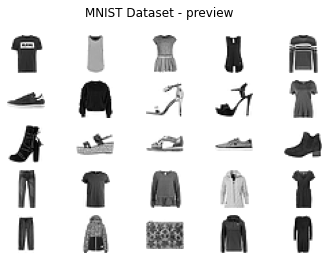

In [6]:
ROW_IMG = 5
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG*N_ROWS + 1):
  plt.subplot(N_ROWS,ROW_IMG, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

Text(0.5, 0.98, 'FashionMNIST Dataset')

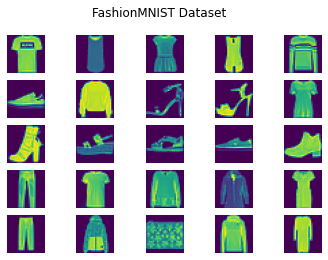

In [7]:
fig = plt.figure()
for index in range(1, ROW_IMG*N_ROWS + 1):
  plt.subplot(N_ROWS, ROW_IMG, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index])
fig.suptitle('FashionMNIST Dataset')

# TODO - 4: Helper Functions

In [71]:
def get_accuracy(model, data_loader, device):
    ''' 
    Function for computing the accuracy of the predictions over the entire dataloader
    '''
    correct_preds = 0
    total_num = 0

    with torch.no_grad():
      model.eval()

      for X,y_true in data_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        _, y_prob = model(X) # model(x) returns a tensor of size (BATCH_SIZE, NUM_CLASSES) - tensor([32,10])
        _, predicted_labels = torch.max(y_prob, dim=1)

        total_num += y_true.size(0)
        correct_preds += (predicted_labels == y_true).sum()
      
      return correct_preds.float() / total_num

def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum()

In [10]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig,ax = plt.subplots(figsize = (8,4.5))

    ax.plot(train_losses, color='blue', label='Training Loss')
    ax.plot(valid_losses, color='red', label='validation Loss')

    ax.set(title = 'Loss over epochs', xlabel='Epoch', ylabel='Loss')
    ax.legend()
    fig.show()

    # Change the plot style to default
    plt.style.use('default')


# TODO - 5: Training Functions

In [100]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of training loop
    '''
    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        preds, _ = model(X)
        loss = criterion(preds, y_true) # Categorical Cross Entropy Loss function

        running_loss += loss.item() * X.size(0)

        

        '''
        V.V.IMP: https://stackoverflow.com/questions/61092523/what-is-running-loss-in-pytorch-and-how-is-it-calculated#:~:text=item()%20contains%20the%20loss,batch%20size%2C%20given%20by%20inputs.
        Check the abve link for reference understanding

        # if the batch_size is 4, loss.item() would give the loss for the entire set of 4 images
        That depends on how the loss is calculated. Remember, loss is a tensor just like every other tensor. 
        In general the PyTorch APIs return avg loss by default
        "The losses are averaged across observations for each minibatch."
        '''

        # Backward pass
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()

    epoch_loss = running_loss / len(train_loader.dataset) # Loss over each epoch (Different than running loss)
    return model, optimizer, epoch_loss

In [101]:
def validate(valid_loader, model, criterion, optimizer,device):
    '''
    Function for validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

      X = X.to(device)
      y_true = y_true.to(device)

      # Forward pass and record loss
      preds, _ = model(X)
      loss = criterion(preds, y_true)
      running_loss += loss.item() * X.size(0)      
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

## Save model checkpoint

In [50]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)



def load_checkpoint(checkpoint):
    print("=> Loading Checkpoint")
    model.load_state_dict(checkpoint['state_dict']) # V.V.IMP - Read the Dictionary
    optimizer.load_state_dict(checkpoint['optimizer']) # That you saved and place the name in [] here accordingly


In [52]:
load_model = True

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"))

In [104]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader,
                  epochs, device, print_every = 1):
  
    ''' 
    Function defining the entire training loop
    '''
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(epochs):

      if epoch % 2 == 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)

      # Training
      model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
      train_losses.append(train_loss)

      # Validation
      with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, optimizer, device)
        valid_losses.append(valid_loss)

      if epoch % print_every == 0:

          train_acc = get_accuracy(model, train_loader, device = device)
          valid_acc = get_accuracy(model, valid_loader, device = device)

          print(f'{datetime.now().time().replace(microsecond=0)}---'
                f'Epoch: {epoch}\t'
                f'Train Loss:{train_loss:.2f}\t\t'
                f'Valid Loss:{valid_loss:.2f}\t\t'
                f'Train accuracy:{100 * train_acc:.4f}\t\t'
                f'Valid accuracy:{100 * valid_acc:.4f}\t\t')
          
    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

# TODO - 6: Implement LeNet Architecture

In [23]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
      super(LeNet5, self).__init__()

      self.feature_extractor = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5,stride = 1), # reduced to 28 X 28 from 32 X 32
          nn.Tanh(),                                                               # (5 X 5 X 6) + 6 = Number of Trainable Parameters: +6 for Bias
          nn.AvgPool2d(kernel_size = 2), # reduced to 14 X 14 from 28 X 28            ( [N +2p -f / S] + 1) 
          
          nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1),
          nn.Tanh(),
          nn.AvgPool2d(kernel_size = 2),

          nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1),
          nn.Tanh(),
      )

      self.classifier = nn.Sequential(
          nn.Linear(in_features = 120, out_features = 84),
          nn.Tanh(),
          nn.Linear(in_features = 84, out_features = n_classes)
      )

    def forward(self, x):

        x = self.feature_extractor(x)
        x = x.reshape(x.shape[0], -1)

        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)

        return logits, probs

# TODO 7: Start Training

## Parameters

In [21]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 5

IMG_SIZE = 32
N_CLASSES = 10

=> Saving Checkpoint
06:57:53---Epoch: 0	Train Loss:0.62		Valid Loss:0.47		Train accuracy:83.7900		Valid accuracy:83.1200		
06:58:08---Epoch: 1	Train Loss:0.42		Valid Loss:0.42		Train accuracy:85.8200		Valid accuracy:84.4600		
=> Saving Checkpoint
06:58:24---Epoch: 2	Train Loss:0.37		Valid Loss:0.38		Train accuracy:87.7383		Valid accuracy:86.1400		
06:58:39---Epoch: 3	Train Loss:0.33		Valid Loss:0.36		Train accuracy:88.8317		Valid accuracy:87.0200		
=> Saving Checkpoint
06:58:54---Epoch: 4	Train Loss:0.31		Valid Loss:0.35		Train accuracy:89.1533		Valid accuracy:86.9700		


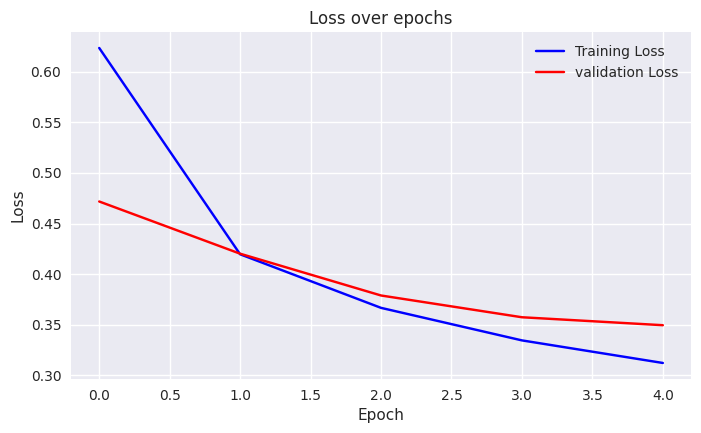

In [55]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, device)